#Setup

In [57]:
# Reproducibility
import numpy as np
random_state = 0
np.random.seed(random_state)

# Data description
n_subjects = 100
n_timepoints = 20

# RF hyperparameters
n_estimators = 50
max_depth = 10
bootstrap_fraction = 0.6 #how many datapoint (or subjects) are given to each tree

# Generate longitudinal dataset

Here we have time, as a number (up to `n_timepoints`). Two features (`X1` and `X2`) depend on it. The target variable `y` depends on the features.

In [58]:
import pandas as pd

data = []

for subject_id in range(n_subjects):
    for time in range(n_timepoints):
        X1 = 0.5 * time
        X2 = 3 * np.sin(time)
        y = X1 + X2 + np.random.normal(0, 0.5)  # target depends on features plus noise
        data.append({
            'subject_id': f'subject_{subject_id}',
            'time' : time,
            'X1': X1,
            'X2': X2,
            'y': y
        })

df = pd.DataFrame(data)

print(df)

      subject_id  time   X1        X2         y
0      subject_0     0  0.0  0.000000  0.882026
1      subject_0     1  0.5  2.524413  3.224492
2      subject_0     2  1.0  2.727892  4.217261
3      subject_0     3  1.5  0.423360  3.043807
4      subject_0     4  2.0 -2.270407  0.663372
...          ...   ...  ...       ...       ...
1995  subject_99    15  7.5  1.950864  9.499739
1996  subject_99    16  8.0 -0.863710  7.837052
1997  subject_99    17  8.5 -2.884192  5.695024
1998  subject_99    18  9.0 -2.252962  6.176088
1999  subject_99    19  9.5  0.449632  9.294146

[2000 rows x 5 columns]


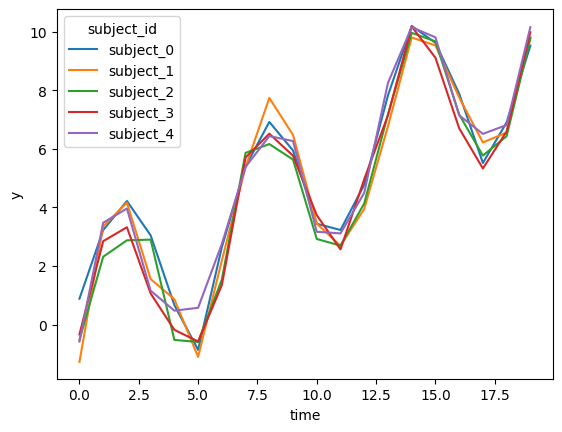

In [59]:
# let's take a look at the first few subjects
sel = df['subject_id'].isin(['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4'])
mydf = df[sel]

#plotting y against time, coloring by subject
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=mydf, x='time', y='y', hue='subject_id')
plt.show()

# The historical features: lag window

In [60]:
# A function that puts the previous features side by side to the current one
def create_historical_features(df, n_lags=2):
    df = df.sort_values(['subject_id', 'time'])
    for lag in range(1, n_lags + 1):
        for col in ['X1', 'X2']:
            df[f'{col}_lag{lag}'] = df.groupby('subject_id')[col].shift(lag)
    df = df.dropna()
    return df

# Prepare data and take a look
df_H = create_historical_features(df)
print(df_H)

      subject_id  time   X1        X2         y  X1_lag1   X2_lag1  X1_lag2  \
2      subject_0     2  1.0  2.727892  4.217261      0.5  2.524413      0.0   
3      subject_0     3  1.5  0.423360  3.043807      1.0  2.727892      0.5   
4      subject_0     4  2.0 -2.270407  0.663372      1.5  0.423360      1.0   
5      subject_0     5  2.5 -2.876773 -0.865412      2.0 -2.270407      1.5   
6      subject_0     6  3.0 -0.838246  2.636798      2.5 -2.876773      2.0   
...          ...   ...  ...       ...       ...      ...       ...      ...   
1995  subject_99    15  7.5  1.950864  9.499739      7.0  2.971822      6.5   
1996  subject_99    16  8.0 -0.863710  7.837052      7.5  1.950864      7.0   
1997  subject_99    17  8.5 -2.884192  5.695024      8.0 -0.863710      7.5   
1998  subject_99    18  9.0 -2.252962  6.176088      8.5 -2.884192      8.0   
1999  subject_99    19  9.5  0.449632  9.294146      9.0 -2.252962      8.5   

       X2_lag2  
2     0.000000  
3     2.524413  


# Separating train and validation sets

In [61]:
# Separating the subject that go into train and validation set
subjects = df_H['subject_id'].unique()
np.random.shuffle(subjects)
n_train = int(0.8 * len(subjects))
train_subjects = subjects[0:n_train]
val_subjects   = subjects[n_train:]

# Separating the actual data, so that info on the train subjects doesn't
# spill into the validation set
train_df_H = df_H[df_H['subject_id'].isin(train_subjects)]
val_df_H   = df_H[df_H['subject_id'].isin(val_subjects)]

# The updated list of features (this is necessary because of the lag columns,
# which may vary)
features_H = list(set(df_H.columns) - set(['y', 'subject_id']))

# For easier interface, we also further split the data in X and y
X_train_H = train_df_H[features_H]
y_train_H = train_df_H['y']

X_val_H = val_df_H[features_H]
y_val_H = val_df_H['y']

In [62]:
# Train Historical RF, get the predictions
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_H = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, max_samples=bootstrap_fraction, max_depth=max_depth)
rf_H.fit(X_train_H, y_train_H)
y_pred_rf_H = rf_H.predict(X_val_H)
print(f"Historical RF R2 score: {r2_score(y_val_H, y_pred_rf_H):.4f}")

Historical RF R2 score: 0.9757


# Exploring the hyperparameter: lag window

We want to try several values for the lag window size. To do so first we need a handy function to create the various train/val sets on the fly.

In [63]:
def create_sets(df, n_lags, train_split = 0.8):
    # First, let's create the historical set using the previously defined function
    df_H = create_historical_features(df, n_lags)

    # Then, we separate the subject that go into train and validation set
    subjects = df_H['subject_id'].unique()
    np.random.shuffle(subjects)
    n_train = int(train_split * len(subjects))
    train_subjects = subjects[0:n_train]
    val_subjects   = subjects[n_train:]

    # Separating the actual data, so that info on the train subjects doesn't
    # spill into the validation set
    train_df_H = df_H[df_H['subject_id'].isin(train_subjects)]
    val_df_H   = df_H[df_H['subject_id'].isin(val_subjects)]

    # The updated list of features (this is necessary because of the lag columns,
    # which may vary)
    features_H = list(set(df_H.columns) - set(['y', 'subject_id']))

    # For easier interface, we also further split the data in X and y
    X_train_H = train_df_H[features_H]
    y_train_H = train_df_H['y']

    X_val_H = val_df_H[features_H]
    y_val_H = val_df_H['y']

    #and we are done
    return X_train_H, y_train_H, X_val_H, y_val_H

We can now test several values for `n_lags`

In [64]:
for n_lags in [1, 2, 3, 4, 5, 10]:
    X_train_H, y_train_H, X_val_H, y_val_H = create_sets(df, n_lags)
    rf_H = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, max_samples=bootstrap_fraction, max_depth=max_depth)
    rf_H.fit(X_train_H, y_train_H)
    y_pred_rf_H = rf_H.predict(X_val_H)
    print(f"Historical RF, lag: {n_lags} R2 score: {r2_score(y_val_H, y_pred_rf_H):.4f}")

Historical RF, lag: 1 R2 score: 0.9767
Historical RF, lag: 2 R2 score: 0.9783
Historical RF, lag: 3 R2 score: 0.9768
Historical RF, lag: 4 R2 score: 0.9776
Historical RF, lag: 5 R2 score: 0.9708
Historical RF, lag: 10 R2 score: 0.9640
